In [1]:
import os
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle as pickle

In [2]:
import prince.config
from prince import core, util, photonfields, cross_sections
from prince import util as pru

CUPY not found for GPU support. Degrading to MKL.


# **Important**: Run `Create_Kernel.ipynb` before trying this example

# Reload the pickled kernel

You need to reload the kenrel that was pickled in the example in   `examples/Create_Kernel.ipynb`

Adjust the path to where you saved it to

In [3]:
%%time
target_path = os.path.expanduser("./prince_kernels/")
with open(target_path + 'prince_run_talys_test.ppo','rb') as thefile:
    prince_run = pickle.load(thefile)

CPU times: user 1.72 s, sys: 10.2 s, total: 11.9 s
Wall time: 14.4 s


# Run a solver using the loaded kernel

**Note:** We use a backward differentiation solver (BDF) here (`UHECRPropagationSolverBDF`)  
There are other options in `prince/solvers`, however these are not robustly tested.  
**So when in doubt use BDF**

In [4]:
from prince.solvers import UHECRPropagationSolverBDF
from prince.cr_sources import AugerFitSource,RigdityCutoffSource

**Note:** The photonfield was set together with the solver in `examples/Create_Kernel.ipynb`

However we can still replace it here:

In [5]:
pf_gilmore = photonfields.CombinedPhotonField(
    [photonfields.CMBPhotonSpectrum,photonfields.CIBGilmore2D])
prince_run.int_rates.photon_field = pf_gilmore

**Step 1:** Initiate solver class

In [6]:
solver = UHECRPropagationSolverBDF(initial_z=1., final_z = 0.,prince_run=prince_run,
                                   enable_pairprod_losses = True, enable_adiabatic_losses = True,
                                   enable_injection_jacobian = True, enable_partial_diff_jacobian=True)

**Step 2:** Create a source class and add it to the solver

**Note:** There are more source classes defined in `prince/sources.py`

In [7]:
rmax = 10**9.68
gamma = 0.96
total_norm = 1e-50

f_hydrogen = 0.
f_helium = 67.3
f_nitrogen = 28.1
f_silicon = 4.6
f_iron = 0.

# NOTE: You can add as much as you want here.
# you can also add several source classes. But that will be slower, if there are many
solver.add_source_class(
    AugerFitSource(prince_run, norm = total_norm,
                   params={101: (gamma, rmax, f_hydrogen),
                           402: (gamma, rmax, f_helium),
                           1407: (gamma, rmax, f_nitrogen),
                           2814: (gamma, rmax, f_silicon),
                           5626: (gamma, rmax, f_iron)}))

**Note:** We add here only one source, but one could in principle add any number of sources here  
(For a large number of different source classes, the solver will get slow)

**Step 3:** Run the solver

In [8]:
%time solver.solve(dz=1e-3,verbose=False,progressbar=True)

1007it [00:39, 25.82it/s]                           

CPU times: user 1min 11s, sys: 3.45 s, total: 1min 14s
Wall time: 44.3 s


# Now plot the result

In [9]:
from prince_analysis_tools.spectra import auger2015, auger2017
data = auger2017
data_label = 'Auger 2017'

First normalize roughly to the spectrum

In [10]:
result = solver.res

edata = auger2015['energy']
norm = auger2015['spectrum'][17] / result.get_solution_group('CR',egrid=edata)[1][17]
print(f'{norm:.2e}')

result = result * norm

3.24e+04


/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),


### Plot the spectrum

/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: divide by zero encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),


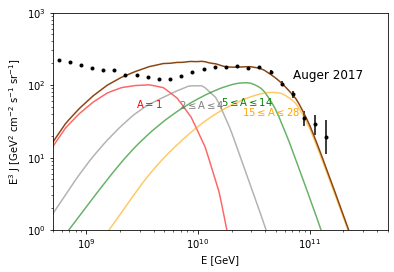

In [11]:
import matplotlib.pyplot as plt

ncoid2sref = result.spec_man.ncoid2sref
A = lambda x: ncoid2sref[x].A

for group, color, label, loffset in zip([(A,1,1),(A,2,4),(A,5,14),(A,15,28),(A,29,56)],
                             ['red','gray','green','orange','blue'],
                             [r'$\mathrm{A} = 1$',r'$2 \leq \mathrm{A} \leq 4$',r'$5 \leq \mathrm{A} \leq 14$',
                              r'$15 \leq \mathrm{A} \leq 28$','$29 \leq \mathrm{A} \leq 56$'],
                             [0, 0, 0 , 0, 0]):

    energy, spectrum = result.get_solution_group(group)
    l = plt.loglog(energy, spectrum, label=label, c=color, alpha = 0.6)
    maxidx = spectrum.argmax()
    loc = (energy[maxidx+loffset], spectrum[maxidx+loffset] / 1.5)
    
    # only plot annotations, if they are roughly within plot range
    # otherwise there are clipping errors
    if 5e8 < loc[0] < 5e11 and 1e0 < loc[1] < 1e3:
        plt.annotate(label, loc, color=color, weight = 'bold', fontsize = 10,
                    horizontalalignment='center', verticalalignment='top')

energy, spectrum = result.get_solution_group('CR')
l = plt.loglog(energy, spectrum, c='saddlebrown')

plt.errorbar(data['energy'], data['spectrum'],
             yerr=(data['lower_err'], data['upper_err']),
             fmt='o', color='black', label = data_label,markersize=3)
plt.annotate(data_label,(data['energy'][-4],data['spectrum'][-4]*1.5),fontsize=12,
             horizontalalignment='left', verticalalignment='bottom')
# plt.legend(ncol=1, loc='lower left', fontsize='small')

plt.xlim(5e8,5e11)
plt.ylim(1e0,1e3)

plt.ylabel('E$^3$ J [GeV$^{2}$ cm$^{-2}$ s$^{-1}$ sr$^{-1}$]')
plt.xlabel('E [GeV]')

plt.show()

### Plot the composition

In [12]:
from prince_analysis_tools.xmax import XmaxSimple
from prince_analysis_tools.spectra import Xmax2015,Xmax2017,XRMS2015,XRMS2017

Helper functions for plotting

In [13]:
# %load ../scripts/xmax_plot.py
def make_error_boxes(xdata, ydata, xerror, yerror, facecolor='r',
                     edgecolor='None', alpha=0.5):

    ax = plt.gca()
    from matplotlib.collections import PatchCollection
    from matplotlib.patches import Rectangle

    # Create list for all the error patches
    errorboxes = []

    # Loop over data points; create box from errors at each point
    for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T):
        rect = Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
        errorboxes.append(rect)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
                         edgecolor=edgecolor)

    # Add collection to axes
    ax.add_collection(pc)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

### Plot the mean $\langle X_\mathrm{max} \rangle$

/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:140: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:148: RuntimeWarning: invalid value encountered in true_divide
  lnA[:, np.newaxis] * spectra).sum(axis=0) / spectra.sum(axis=0)
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:150: RuntimeWarning: invalid value encountered in true_divide
  spectra).sum(axis=0) / spectra.sum(axis=0) - average**2


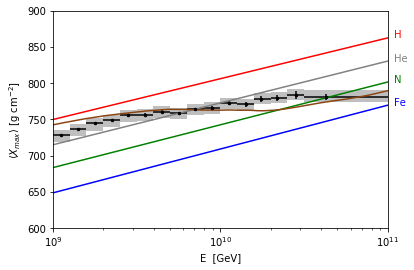

In [14]:
deltaE = 0.
xshift=0.
model=XmaxSimple(model=XmaxSimple.EPOSLHC)
data=Xmax2017
data_label=r'\langle Xmax \rangle Auger 2017'
    
egrid, average, variance = result.get_lnA([el for el in result.known_species if el >= 100])
energy = egrid
energy *= 1 + deltaE
mean_lnA = average
sigma_lnA = variance

import matplotlib.pyplot as plt
# plot the reference models
for A, c, name in zip([1,4,14,56], ['red','gray','green','blue'],['H','He','N','Fe']):
    Xmax = model.get_mean_Xmax(np.log(A), energy)
    plt.semilogx(energy,Xmax, color = c)
    idx = find_nearest(energy,1e11)
    plt.annotate(name,(energy[idx+1],Xmax[idx]),color = c,annotation_clip=False)

Xmax = model.get_mean_Xmax(mean_lnA, energy)
plt.semilogx(energy, Xmax, color = 'saddlebrown', ls ='solid')

xerr = np.array((data['energy_Low'], data['energy_Up']))
yerr = np.array((data['sys_Low'], data['sys_Up']))
make_error_boxes(data['energy'], data['val'], xerr, yerr, facecolor='gray')

if xshift > 0:
    xcorr = xshift * data['sys_Up']
else:
    xcorr = xshift * data['sys_Low']

plt.errorbar(data['energy'], data['val'] + xcorr,
             xerr=(data['energy_Low'], data['energy_Up']),
             yerr=(data['stat'], data['stat']),
             fmt='o',markersize=2.5, label=data_label, c='black')

plt.xlim(1e9,1e11)
plt.ylim(600,900)
plt.xlabel('E  [GeV]')
plt.ylabel(r'$\langle X_{max} \rangle$ [g cm$^{-2}$]')

plt.show()

### Plot the variance $\sigma(X_\mathrm{max})$

/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:140: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:148: RuntimeWarning: invalid value encountered in true_divide
  lnA[:, np.newaxis] * spectra).sum(axis=0) / spectra.sum(axis=0)
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:150: RuntimeWarning: invalid value encountered in true_divide
  spectra).sum(axis=0) / spectra.sum(axis=0) - average**2


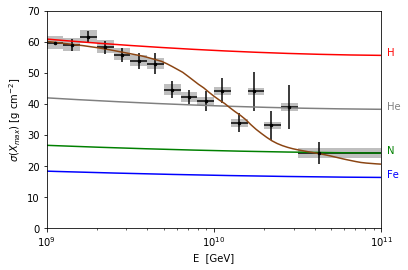

In [15]:
deltaE = 0.
xshift=0.
model=XmaxSimple(model=XmaxSimple.EPOSLHC)
data=XRMS2017
data_label=r'\langle Xmax \rangle Auger 2017'
    
egrid, average, variance = result.get_lnA([el for el in result.known_species if el >= 100])
energy = egrid
energy *= 1 + deltaE
mean_lnA = average
var_lnA = variance

import matplotlib.pyplot as plt
for A, c, name in zip([1,4,14,56], ['red','gray','green','blue'],['H','He','N','Fe']):
    sigmaXmax, sigmaXmax_part = np.sqrt(model.get_var_Xmax(np.log(A), 0., energy))
    plt.semilogx(energy,sigmaXmax, color = c)
    idx = find_nearest(energy,1e11)
    plt.annotate(name,(energy[idx+1],sigmaXmax[idx]),color = c,annotation_clip=False)

sigmaXmax, sigmaXmax_part = np.sqrt(model.get_var_Xmax(mean_lnA, var_lnA, energy))
plt.semilogx(energy,sigmaXmax, color = 'saddlebrown', ls ='solid')
#     plt.semilogx(energy,sigmaXmax_part, color = 'saddlebrown', ls ='dashed')

xerr = np.array((data['energy_Low'], data['energy_Up']))
yerr = np.array((data['sys_Low'], data['sys_Up']))
make_error_boxes(data['energy'], data['val'], xerr, yerr, facecolor='gray')

if xshift > 0:
    xcorr = xshift * data['sys_Up']
else:
    xcorr = xshift * data['sys_Low']

plt.errorbar(data['energy'], data['val'] + xcorr,
             xerr=(data['energy_Low'], data['energy_Up']),
             yerr=(data['stat'], data['stat']),
             fmt='o',markersize=2.5, label='Xmax Auger 2015', c='black')

plt.xlim(1e9,1e11)
plt.ylim(0,70)
plt.xlabel('E  [GeV]')
plt.ylabel(r'$\sigma( X_{max})$ [g cm$^{-2}$]')

plt.show()

### Cosmogenic Neutrinos

/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: invalid value encountered in log
  np.log(curr_spec),
/home/jheinze/python_packages/PriNCe/prince/solvers/propagation.py:120: RuntimeWarning: divide by zero encountered in log
  np.log(curr_spec),


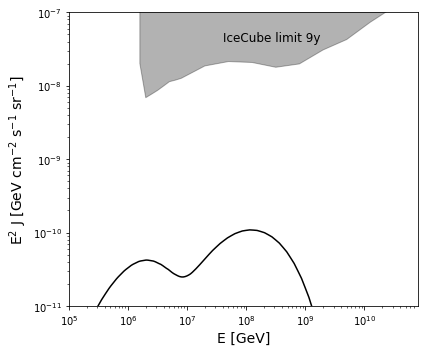

In [16]:
plt.figure(figsize=(6,5))

alpha = 0.3
handles=[]

egrid, spec = result.get_solution_group('nu',epow=2)
plt.loglog(egrid,spec,c='black',label='best fit')

from prince_analysis_tools.spectra import IClimit2017, IClimit2017GRB, IClimit9year
from prince_analysis_tools.spectra import IClimit9year_new as IClimit9year

plt.fill_between(IClimit9year['energy'], IClimit9year['limit'], np.ones_like(IClimit9year['energy']),
                 color='black',alpha= 0.3)
plt.annotate('IceCube limit 9y',(4e7,4e-8), fontsize = 'large')

plt.ylim(1e-11,1e-7)
plt.xlim(1e5,IClimit9year['energy'][-1].value)

plt.ylabel('E$^2$ J [GeV cm$^{-2}$ s$^{-1}$ sr$^{-1}$]',fontsize=14)
plt.xlabel('E [GeV]',fontsize=14)

plt.tight_layout()

plt.show()